In [17]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
import healpy as hp
import warnings
import matplotlib.colors as mcolors

import cartopy
from ulmo.analysis.spatial_plots import evals_to_healpix, evals_to_healpix_stat, show_med_LL

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# this should be run in JupyterHub

In [2]:
analysis_table = pandas.read_parquet('/home/jovyan/SST_L3S_VIIRS_2012.parquet')

In [3]:
eval_tbl = analysis_table
nside = 64

In [4]:
hpma, hp_lons, hp_lats, hp_values = evals_to_healpix_stat(eval_tbl, nside, stat = 'median') # read table, evaulate log likelihood

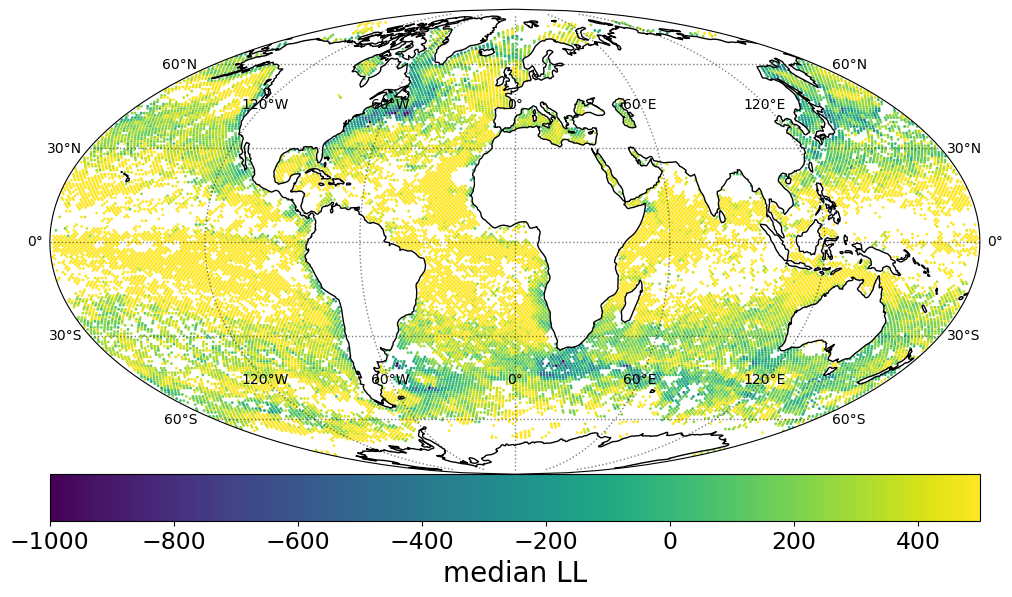

In [5]:
fig = plt.figure(figsize=(12,8)) # makes plot
color='viridis'
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)

cm = plt.get_cmap(color)
good = np.invert(hp_values.mask)
img = plt.scatter(x=hp_lons[good],
    y=hp_lats[good],
    c=hp_values[good], vmin = -1000, vmax = 500, 
    cmap=cm,
    s=1,
    transform=tformP)

cb = plt.colorbar(img, orientation='horizontal', pad=0.)
clbl = 'median LL'
cb.set_label(clbl, fontsize=20.)
cb.ax.tick_params(labelsize=17)
ax.coastlines(zorder=10)
ax.set_global()
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1,
                  color='black', alpha=0.5, linestyle=':', draw_labels=True)

gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}

plt.show()

In [6]:
# make differences in LL plot

hpma, hp_lons, hp_lats, hp_values_L2 = evals_to_healpix_stat(eval_tbl, nside, stat = 'median', metric = 'VIIRS_LL')
hpma, hp_lons, hp_lats, hp_values_L3S = evals_to_healpix_stat(eval_tbl, nside, stat = 'median', metric = 'LL')

hp_diff = hp_values_L2 - hp_values_L3S

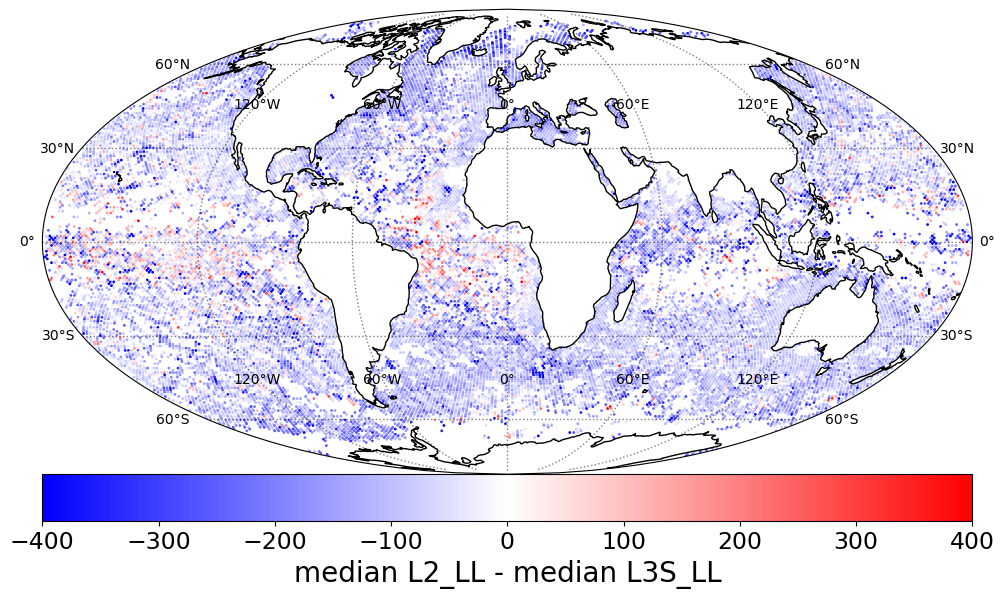

In [9]:
fig = plt.figure(figsize=(12,8)) # makes plot
color='bwr'
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)

cm = plt.get_cmap(color)
good = np.invert(hp_diff.mask)
img = plt.scatter(x=hp_lons[good],
    y=hp_lats[good],
    c=hp_diff[good], vmin = -400, vmax = 400, 
    cmap=cm,
    s=1,
    transform=tformP)

cb = plt.colorbar(img, orientation='horizontal', pad=0.)
clbl = 'median L2_LL - median L3S_LL'
cb.set_label(clbl, fontsize=20.)
cb.ax.tick_params(labelsize=17)
ax.coastlines(zorder=10)
ax.set_global()
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1,
                  color='black', alpha=0.5, linestyle=':', draw_labels=True)

gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}

plt.show()

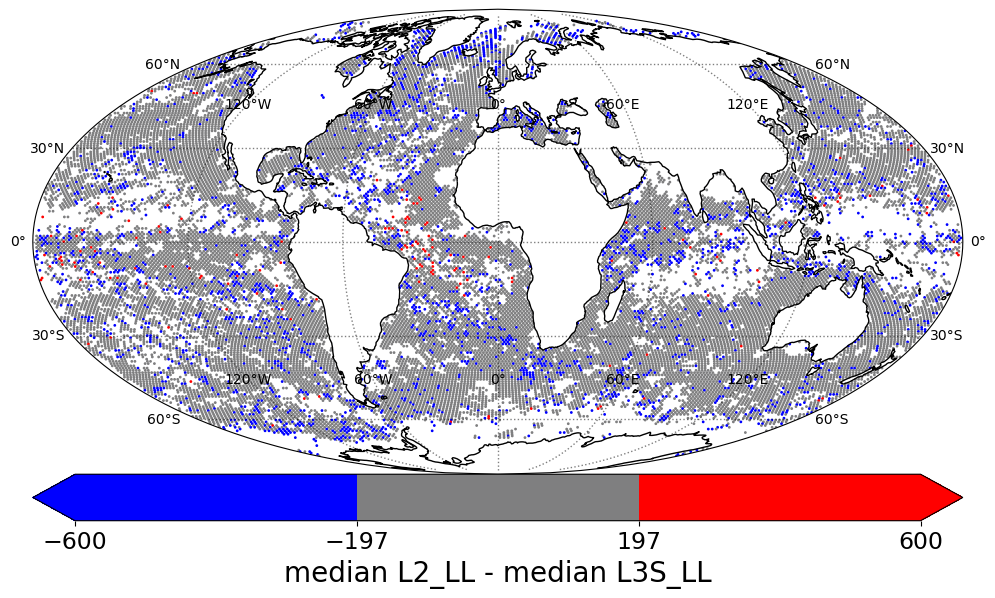

In [25]:
fig = plt.figure(figsize=(12, 8))  # makes plot
color = 'bwr'
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)

# Create a custom colormap with gray in the middle
cmap = plt.cm.bwr
gray_color = np.array([0.5, 0.5, 0.5, 1.0])  # Gray color in RGBA format (R, G, B, Alpha)
bounds = [-600, -197, 197, 600]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [cmap(0), gray_color, cmap(cmap.N-1)], N=cmap.N)

# Plot the scatter with custom colormap and normalization
img = plt.scatter(x=hp_lons[good],
                 y=hp_lats[good],
                 c=hp_diff[good],
                 cmap=cmap,
                 norm=norm,
                 s=1,
                 transform=tformP)

# Create a custom colorbar with gray for values between -197 and 197
cbar = plt.colorbar(img, orientation='horizontal', pad=0., cmap=cmap, norm=norm, extend='both')
cbar.ax.tick_params(labelsize=17)
clbl = 'median L2_LL - median L3S_LL'
cbar.set_label(clbl, fontsize=20.)

ax.coastlines(zorder=10)
ax.set_global()

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1,
                  color='black', alpha=0.5, linestyle=':', draw_labels=True)

gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}

plt.show()

In [49]:
valid_hp_diff = hp_diff[good]
sum_valid_hp_diff = np.sum(valid_hp_diff)
threshold = 197
percentage_outside_range = (np.count_nonzero(valid_hp_diff < -threshold) + np.count_nonzero(valid_hp_diff > threshold)) / len(valid_hp_diff) * 100

In [50]:
percentage_outside_range

12.421211866543407

In [56]:
mean = np.nanmean(valid_hp_diff)
std = np.nanstd(valid_hp_diff)

range_value = mean + 2 * std
range_negative = mean - 2 * std

print("Mean of valid hp_diff values:", mean)
print("Standard Deviation of valid hp_diff values:", std)
print("Range:", range_value)
print("Negative Range:", range_negative)

# range used in previous paper is -197 to 197, 5% of valid data
# was outside of these ranges

Mean of valid hp_diff values: -96.28473347788926
Standard Deviation of valid hp_diff values: 107.85597386324456
Range: 119.42721424859985
Negative Range: -311.9966812043784


In [39]:
# get h5 file and scatterplot

hdf5_file_path = '/home/jovyan/L3S_VIIRS144_2012_preproc.h5'

with h5py.File(hdf5_file_path, 'r') as h5_file:
    valid = h5_file['valid'][:]
    metadata = h5_file['valid_metadata'][:]

In [41]:
cutout_indices = metadata[:, [8, 20, 21, 33, 34]]
decoded_data = [[float(item.decode('utf-8')) for item in row] for row in cutout_indices]
column_names = ['VIIRS_DT', 'lat', 'lon', 'T90', 'T10']
df = pandas.DataFrame(decoded_data, columns = column_names)

df.loc[:,'DT'] = df.loc[:,'T90'] - df.loc[:,'T10']
df.loc[:,'diff_DT'] = df.loc[:,'VIIRS_DT'] - df.loc[:,'DT']

In [44]:
print("Minimum value:", np.min(df.loc[:,'diff_DT']))
print("Maximum value:", np.max(df.loc[:,'diff_DT']))
print("Mean:", np.mean(df.loc[:,'diff_DT']))
print("Standard Deviation:", np.std(df.loc[:,'diff_DT']))

Minimum value: -2.8499755859375
Maximum value: 8.989990234375
Mean: 0.2114112997548144
Standard Deviation: 0.39631375037787897


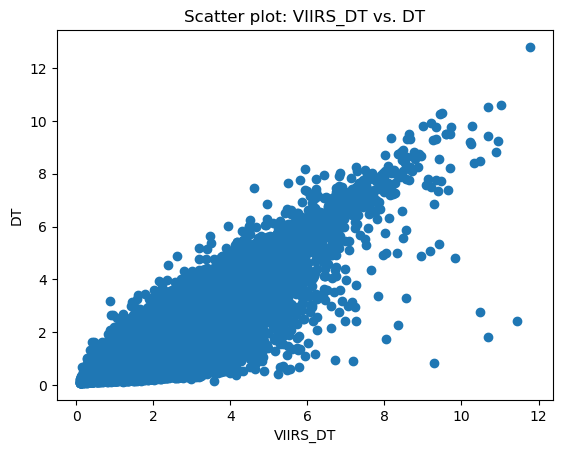

In [46]:
filtered_df = df[df['DT'] != 0]
plt.scatter(filtered_df['VIIRS_DT'], filtered_df['DT'])
plt.xlabel('VIIRS_DT')
plt.ylabel('DT')
plt.title('Scatter plot: VIIRS_DT vs. DT')
plt.show()